# Домашнее задание №1
## Часть 1: Механизм внимания (Attention)
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/rads_ai

В данном задании вам предстоит детально рассмотреть механизм Attention (и реализовать несколько его вариантов).

In [1]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

### Реализация Attention

В данной задаче вам предстоит реализовать механизм Attention, в частности несколько способов подсчета attention scores. Конечно, в популярных фреймворках данный механизм уже реализован, но для лучшего понимания вам предстаит реализовать его с помощью `numpy`.

Ваше задание в данной задаче: реализовать `additive` (аддитивный) и `multiplicative` (мультипликативный) варианты Attention. Для вашего удобства (и для примера) `dot product` attention (основанный на скалярном произведении) уже реализован.

Детальное описание данных типов Attention доступно в лекционных слайдах.

Text(0.5, 1.0, 'Decoder state')

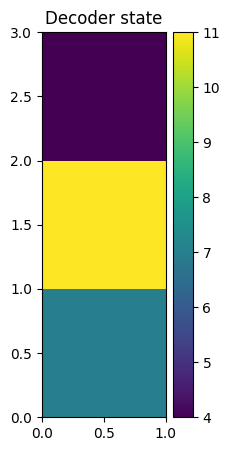

In [2]:
decoder_hidden_state = np.array([7, 11, 4]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(decoder_hidden_state)
plt.colorbar()
plt.title("Decoder state")

#### Dot product attention (пример реализации)
Рассмотрим единственное состояние энкодера – вектор с размерностью `(n_hidden, 1)`, где `n_hidden = 3`:

In [ ]:
single_encoder_hidden_state = np.array([1, 5, 11]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(single_encoder_hidden_state)
plt.colorbar()

Attention score между данными состояниями энкодера и декодера вычисляются просто как скалярное произведение:

In [ ]:
np.dot(decoder_hidden_state.T, single_encoder_hidden_state)

В общем случае состояний энкодера, конечно, несколько. Attention scores вычисляются с каждым из состояний энкодера:

In [ ]:
encoder_hidden_states = (
    np.array([[1, 5, 11], [7, 4, 1], [8, 12, 2], [-9, 0, 1]]).astype(float).T
)

encoder_hidden_states

Тогда для подсчета скалярных произведений между единственным состоянием декодера и всеми состояниями энкодера можно воспользоваться следующей функцией (которая по факту представляет собой просто матричное умножение и приведение типов):

In [ ]:
def dot_product_attention_score(decoder_hidden_state, encoder_hidden_states):
    """
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)

    return: np.array of shape (1, n_states)
        Array with dot product attention scores
    """
    attention_scores = np.dot(decoder_hidden_state.T, encoder_hidden_states)
    return attention_scores

In [ ]:
dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)

Для подсчета "весов" нам необходим Softmax:

In [ ]:
def softmax(vector):
    """
    vector: np.array of shape (n, m)

    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    """
    nice_vector = vector - vector.max()
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1)[:, np.newaxis]
    softmax_ = exp_vector / exp_denominator
    return softmax_

In [ ]:
weights_vector = softmax(
    dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)
)

weights_vector

Наконец, воспользуемся данными весами и вычислим итоговый вектор, как и описано для dot product attention.

In [ ]:
attention_vector = weights_vector.dot(encoder_hidden_states.T).T
print(attention_vector)

plt.figure(figsize=(2, 5))
plt.pcolormesh(attention_vector, cmap="spring")
plt.colorbar()

Данный вектор аккумулирует в себе информацию из всех состояний энкодера, взвешенную на основе близости к заданному состоянию декодера.

Реализуем все вышеописанные преобразования в единой функции:

In [ ]:
def dot_product_attention(decoder_hidden_state, encoder_hidden_states):
    """
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)

    return: np.array of shape (n_features, 1)
        Final attention vector
    """
    softmax_vector = softmax(
        dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)
    )
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T
    return attention_vector

In [ ]:
assert (
    attention_vector
    == dot_product_attention(decoder_hidden_state, encoder_hidden_states)
).all()

#### Multiplicative attention
Ваша текущая задача: реализовать multiplicative attention.
$$ e_i = \mathbf{s}^TW_{mult}\mathbf{h}_i $$

Матрица весов `W_mult` задана ниже.
Стоит заметить, что multiplicative attention позволяет работать с состояниями энкодера и декодера различных размерностей, поэтому состояния энкодера будут обновлены:

In [ ]:
encoder_hidden_states_complex = (
    np.array([[1, 5, 11, 4, -4], [7, 4, 1, 2, 2], [8, 12, 2, 11, 5], [-9, 0, 1, 8, 12]])
    .astype(float)
    .T
)

W_mult = np.array(
    [
        [-0.78, -0.97, -1.09, -1.79, 0.24],
        [0.04, -0.27, -0.98, -0.49, 0.52],
        [1.08, 0.91, -0.99, 2.04, -0.15],
    ]
)

In [ ]:
# your code here

Реализуйте подсчет attention согласно формулам и реализуйте итоговую функцию `multiplicative_attention`:

In [ ]:
def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    """
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_dec, n_features_enc)

    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    """
    # your code here
    return attention_vector

#### Additive attention
Теперь вам предстоит реализовать additive attention.

$$ e_i = \mathbf{v}^T \text{tanh} (W_{add-enc} \mathbf{h}_i + W_{add-dec} \mathbf{s}) $$

Матрицы весов `W_add_enc` и `W_add_dec` доступны ниже, как и вектор весов `v_add`. Для вычисления активации можно воспользоваться `np.tanh`.

In [ ]:
v_add = np.array([[-0.35, -0.58, 0.07, 1.39, -0.79, -1.78, -0.35]]).T

W_add_enc = np.array(
    [
        [-1.34, -0.1, -0.38, 0.12, -0.34],
        [-1.0, 1.28, 0.49, -0.41, -0.32],
        [-0.39, -1.38, 1.26, 1.21, 0.15],
        [-0.18, 0.04, 1.36, -1.18, -0.53],
        [-0.23, 0.96, 1.02, 0.39, -1.26],
        [-1.27, 0.89, -0.85, -0.01, -1.19],
        [0.46, -0.12, -0.86, -0.93, -0.4],
    ]
)

W_add_dec = np.array(
    [
        [-1.62, -0.02, -0.39],
        [0.43, 0.61, -0.23],
        [-1.5, -0.43, -0.91],
        [-0.14, 0.03, 0.05],
        [0.85, 0.51, 0.63],
        [0.39, -0.42, 1.34],
        [-0.47, -0.31, -1.34],
    ]
)

In [ ]:
# your code here

Реализуйте подсчет attention согласно формулам и реализуйте итоговую функцию `additive_attention`:

In [ ]:
def additive_attention(
    decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec
):
    """
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    v_add: np.array of shape (n_features_int, 1)
    W_add_enc: np.array of shape (n_features_int, n_features_enc)
    W_add_dec: np.array of shape (n_features_int, n_features_dec)

    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    """
    # your code here
    return attention_vector

Сдайте функции `multiplicative_attention` и `additive_attention` в контест.

Не забудьте про импорт `numpy`!

In [ ]:
# do not change the code in the block below
# __________start of block__________

np.save("submission_dict_hw08.npy", out_dict, allow_pickle=True)
print("File saved to `submission_dict_hw08.npy`")
# __________end of block__________

На этом задание завершено. Поздравляем!